In [ ]:
# 1. ENVIRONMENT SETUP
# Install required packages and setup environment

!pip install 'gymnasium[atari,accept-rom-license]'
!pip install ale-py autorom[accept-rom-license] JSAnimation torch matplotlib progressbar2
!AutoROM --accept-license

print("✅ All packages installed successfully!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached autorom_accept_rom_license-0.6.1-py3-none-any.whl
  Using cached autorom_accept_rom_license-0.6.1-py3-none-any.whl
  Using cached charset_normalizer-3.4.4-cp311-cp31

# REINFORCE Pong Agent

This notebook implements REINFORCE (Monte Carlo Policy Gradients) to train an agent to play Pong.

## Structure:
1. **Environment Setup** - Initialize Pong environment and dependencies
2. **Agent Training** - Train the REINFORCE agent
3. **Agent Testing** - Test and visualize the trained agent

In [22]:
# Import libraries and setup
import gymnasium as gym
import ale_py
import torch
import numpy as np
import matplotlib.pyplot as plt
from parallelEnv import parallelEnv
import pong_utils

# Handle progressbar import
try:
    import progressbar2 as pb
    print("✅ progressbar2 imported successfully")
except ImportError:
    try:
        import progressbar as pb
        print("✅ progressbar imported successfully")
    except ImportError:
        print("⚠️ No progress bar library found, installing progressbar2...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'progressbar2'])
        import progressbar2 as pb
        print("✅ progressbar2 installed and imported")

# Register ALE environments and setup device
gym.register_envs(ale_py)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

%matplotlib inline

✅ progressbar imported successfully
Using device: cpu


In [23]:
# Initialize Pong environment
try:
    # Try different Pong environment versions
    for env_name in ['PongDeterministic-v4', 'Pong-v4', 'Pong-v0']:
        try:
            env = gym.make(env_name)
            print(f"✅ Successfully created {env_name}")
            break
        except:
            continue
    
    print("Available actions:", env.unwrapped.get_action_meanings())
    
    # Test environment
    obs, info = env.reset()
    print(f"✅ Environment working! Observation shape: {obs.shape}")
    env.close()
    
except Exception as e:
    print(f"❌ Error creating environment: {e}")
    print("Make sure ROMs are installed correctly")

✅ Successfully created Pong-v4
Available actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
✅ Environment working! Observation shape: (210, 160, 3)


# 2. AGENT TRAINING

Initialize the policy network and train the REINFORCE agent using parallel environments.

In [24]:
# Initialize Policy Network
policy = pong_utils.Policy().to(device)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

print("Policy Network:")
print(policy)
print(f"\nTotal parameters: {sum(p.numel() for p in policy.parameters()):,}")

# Training hyperparameters  
num_episodes = 50  # Reduce for faster training, increase for better performance
n_envs = 8  # Number of parallel environments
tmax = 32  # Max timesteps per episode
beta = 0.01  # Entropy regularization
discount_rate = 0.99

print(f"\n🎯 Training Configuration:")
print(f"Episodes: {num_episodes}")
print(f"Parallel Environments: {n_envs}")
print(f"Max Timesteps: {tmax}")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Device: {device}")

Policy Network:
Policy(
  (conv1): Conv2d(2, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (conv2): Conv2d(4, 16, kernel_size=(6, 6), stride=(4, 4))
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

Total parameters: 334,897

🎯 Training Configuration:
Episodes: 50
Parallel Environments: 8
Max Timesteps: 32
Learning Rate: 0.0001
Device: cpu


In [9]:
# REINFORCE Training Loop
envs = parallelEnv(env_name, n=n_envs, seed=1234)

# Progress tracking with fallback
try:
    # Try progressbar2 style
    widget = ['Training: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=num_episodes).start()
except:
    # Fallback to simple progress tracking
    class SimpleProgress:
        def __init__(self, maxval):
            self.maxval = maxval
            self.current = 0
        def update(self, value):
            self.current = value
            if value % 20 == 0:
                print(f"Progress: {value}/{self.maxval} ({100*value/self.maxval:.1f}%)")
        def start(self):
            return self
        def finish(self):
            print(f"Progress: {self.maxval}/{self.maxval} (100.0%)")
    
    timer = SimpleProgress(num_episodes).start()

mean_rewards = []
best_reward = -float('inf')

print("🚀 Starting REINFORCE Training...")
print("This will take approximately 30-45 minutes depending on your hardware.\n")

for episode in range(num_episodes):
    # Collect trajectories from parallel environments
    old_probs, states, actions, rewards = pong_utils.collect_trajectories(
        envs, policy, tmax=tmax
    )
    
    # Calculate total rewards for each environment
    total_rewards = np.sum(rewards, axis=0)
    episode_mean = np.mean(total_rewards)
    mean_rewards.append(episode_mean)
    
    # Update best reward
    if episode_mean > best_reward:
        best_reward = episode_mean
        # Save best model
        torch.save(policy.state_dict(), 'best_pong_policy.pth')
    
    # Calculate policy loss using REINFORCE
    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    # Update policy
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    # Decay entropy regularization
    beta *= 0.995
    
    # Update progress
    timer.update(episode + 1)
    
    # Print progress every 20 episodes
    if (episode + 1) % 20 == 0:
        recent_mean = np.mean(mean_rewards[-20:])
        print(f"\nEpisode {episode+1:3d}: Recent Avg = {recent_mean:6.2f}, Best = {best_reward:6.2f}")
        print(f"Environment Scores: {total_rewards}")

timer.finish()
envs.close()

print(f"\n🎉 Training Complete!")
print(f"Best Average Reward: {best_reward:.2f}")
print(f"Final Average Reward: {np.mean(mean_rewards[-20:]):.2f}")
print(f"Model saved as: best_pong_policy.pth")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
Training:   0% |                                               | ETA:  --:--:--


🚀 Starting REINFORCE Training...
This will take approximately 30-45 minutes depending on your hardware.



/Users/profenghasn/Documents/RL Projects/Policy_Based_RL/reinforce/pong_utils.py:175: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  actions = torch.tensor(actions, dtype=torch.int8, device=device)
Training:   0% |                                               | ETA:   0:15:07
Training:   0% |                                               | ETA:   0:15:07
Training:   0% |                                               | ETA:   0:16:18
Training:   0% |                                               | ETA:   0:16:18
Training:   0% |                                               | ETA:   0:16:12
Training:   0% |                                               | ETA:   0:16:12
Training:   0% |                                               | ETA:


Episode  20: Recent Avg =  -9.99, Best =  -8.50
Environment Scores: [-10. -12.  -5.  -5. -11. -11. -13.  -9.]


Training:   4% |#                                              | ETA:   0:14:19
Training:   4% |##                                             | ETA:   0:14:13
Training:   4% |##                                             | ETA:   0:14:13
Training:   4% |##                                             | ETA:   0:14:07
Training:   4% |##                                             | ETA:   0:14:07
Training:   4% |##                                             | ETA:   0:14:02
Training:   4% |##                                             | ETA:   0:14:02
Training:   5% |##                                             | ETA:   0:13:57
Training:   5% |##                                             | ETA:   0:13:57
Training:   5% |##                                             | ETA:   0:13:53
Training:   5% |##                                             | ETA:   0:13:53
Training:   5% |##                                             | ETA:   0:13:49
Training:   5% |##                      


Episode  40: Recent Avg =  -9.48, Best =  -7.62
Environment Scores: [-12. -11. -11. -11. -10. -12.  -9.  -9.]


Training:   8% |###                                            | ETA:   0:13:13
Training:   8% |###                                            | ETA:   0:13:10
Training:   8% |###                                            | ETA:   0:13:10
Training:   8% |####                                           | ETA:   0:13:07
Training:   8% |####                                           | ETA:   0:13:07
Training:   8% |####                                           | ETA:   0:13:04
Training:   8% |####                                           | ETA:   0:13:04
Training:   9% |####                                           | ETA:   0:13:01
Training:   9% |####                                           | ETA:   0:13:01
Training:   9% |####                                           | ETA:   0:13:01
Training:   9% |####                                           | ETA:   0:13:01
Training:   9% |####                                           | ETA:   0:12:58
Training:   9% |####                    


Episode  60: Recent Avg =  -9.43, Best =  -7.62
Environment Scores: [-12. -11. -11. -12.  -9.  -9.  -9.  -6.]


Training:  12% |#####                                          | ETA:   0:12:22
Training:  12% |#####                                          | ETA:   0:12:19
Training:  12% |#####                                          | ETA:   0:12:19
Training:  12% |#####                                          | ETA:   0:12:17
Training:  12% |#####                                          | ETA:   0:12:17
Training:  12% |######                                         | ETA:   0:12:14
Training:  12% |######                                         | ETA:   0:12:14
Training:  13% |######                                         | ETA:   0:12:13
Training:  13% |######                                         | ETA:   0:12:13
Training:  13% |######                                         | ETA:   0:12:11
Training:  13% |######                                         | ETA:   0:12:11
Training:  13% |######                                         | ETA:   0:12:09
Training:  13% |######                  


Episode  80: Recent Avg =  -9.55, Best =  -7.62
Environment Scores: [-10. -12. -11. -12. -12.  -7. -10. -10.]


Training:  16% |#######                                        | ETA:   0:11:41
Training:  16% |#######                                        | ETA:   0:11:39
Training:  16% |#######                                        | ETA:   0:11:39
Training:  16% |#######                                        | ETA:   0:11:37
Training:  16% |#######                                        | ETA:   0:11:37
Training:  16% |#######                                        | ETA:   0:11:35
Training:  16% |#######                                        | ETA:   0:11:35
Training:  17% |#######                                        | ETA:   0:11:35
Training:  17% |#######                                        | ETA:   0:11:35
Training:  17% |########                                       | ETA:   0:11:34
Training:  17% |########                                       | ETA:   0:11:34
Training:  17% |########                                       | ETA:   0:11:31
Training:  17% |########                


Episode 100: Recent Avg =  -9.68, Best =  -7.62
Environment Scores: [ -9. -11.  -8. -11. -11. -12. -10.  -8.]


Training:  20% |#########                                      | ETA:   0:11:10
Training:  20% |#########                                      | ETA:   0:11:08
Training:  20% |#########                                      | ETA:   0:11:08
Training:  20% |#########                                      | ETA:   0:11:07
Training:  20% |#########                                      | ETA:   0:11:07
Training:  20% |#########                                      | ETA:   0:11:06
Training:  20% |#########                                      | ETA:   0:11:06
Training:  21% |#########                                      | ETA:   0:11:04
Training:  21% |#########                                      | ETA:   0:11:04
Training:  21% |#########                                      | ETA:   0:11:02
Training:  21% |#########                                      | ETA:   0:11:02
Training:  21% |##########                                     | ETA:   0:11:00
Training:  21% |##########              


Episode 120: Recent Avg =  -9.40, Best =  -7.62
Environment Scores: [ -7. -12.  -9. -10.  -9.  -9.  -9. -12.]


Training:  24% |###########                                    | ETA:   0:10:33
Training:  24% |###########                                    | ETA:   0:10:32
Training:  24% |###########                                    | ETA:   0:10:32
Training:  24% |###########                                    | ETA:   0:10:30
Training:  24% |###########                                    | ETA:   0:10:30
Training:  24% |###########                                    | ETA:   0:10:28
Training:  24% |###########                                    | ETA:   0:10:28
Training:  25% |###########                                    | ETA:   0:10:27
Training:  25% |###########                                    | ETA:   0:10:27
Training:  25% |###########                                    | ETA:   0:10:25
Training:  25% |###########                                    | ETA:   0:10:25
Training:  25% |###########                                    | ETA:   0:10:23
Training:  25% |###########             


Episode 140: Recent Avg =  -9.39, Best =  -7.62
Environment Scores: [-12. -10.  -8. -11. -11. -10.  -8.  -9.]


Training:  28% |#############                                  | ETA:   0:10:02
Training:  28% |#############                                  | ETA:   0:10:00
Training:  28% |#############                                  | ETA:   0:10:00
Training:  28% |#############                                  | ETA:   0:09:58
Training:  28% |#############                                  | ETA:   0:09:58
Training:  28% |#############                                  | ETA:   0:09:57
Training:  28% |#############                                  | ETA:   0:09:57
Training:  29% |#############                                  | ETA:   0:09:55
Training:  29% |#############                                  | ETA:   0:09:55
Training:  29% |#############                                  | ETA:   0:09:53
Training:  29% |#############                                  | ETA:   0:09:53
Training:  29% |#############                                  | ETA:   0:09:53
Training:  29% |#############           


Episode 160: Recent Avg =  -9.39, Best =  -7.62
Environment Scores: [-12.  -9.  -9.  -9. -11. -11.  -9.  -9.]


Training:  32% |###############                                | ETA:   0:09:27
Training:  32% |###############                                | ETA:   0:09:26
Training:  32% |###############                                | ETA:   0:09:26
Training:  32% |###############                                | ETA:   0:09:24
Training:  32% |###############                                | ETA:   0:09:24
Training:  32% |###############                                | ETA:   0:09:22
Training:  32% |###############                                | ETA:   0:09:22
Training:  33% |###############                                | ETA:   0:09:22
Training:  33% |###############                                | ETA:   0:09:22
Training:  33% |###############                                | ETA:   0:09:20
Training:  33% |###############                                | ETA:   0:09:20
Training:  33% |###############                                | ETA:   0:09:19
Training:  33% |###############         


Episode 180: Recent Avg =  -9.77, Best =  -7.62
Environment Scores: [-12. -11.  -9. -11.  -9.  -6.  -9. -11.]


Training:  36% |#################                              | ETA:   0:08:56
Training:  36% |#################                              | ETA:   0:08:54
Training:  36% |#################                              | ETA:   0:08:54
Training:  36% |#################                              | ETA:   0:08:53
Training:  36% |#################                              | ETA:   0:08:53
Training:  36% |#################                              | ETA:   0:08:52
Training:  36% |#################                              | ETA:   0:08:52
Training:  37% |#################                              | ETA:   0:08:50
Training:  37% |#################                              | ETA:   0:08:50
Training:  37% |#################                              | ETA:   0:08:48
Training:  37% |#################                              | ETA:   0:08:48
Training:  37% |#################                              | ETA:   0:08:46
Training:  37% |#################       


Episode 200: Recent Avg =  -9.34, Best =  -6.88
Environment Scores: [-12. -11. -12. -10. -12.  -9.  -9. -10.]


Training:  40% |##################                             | ETA:   0:08:22
Training:  40% |##################                             | ETA:   0:08:21
Training:  40% |##################                             | ETA:   0:08:21
Training:  40% |###################                            | ETA:   0:08:20
Training:  40% |###################                            | ETA:   0:08:20
Training:  40% |###################                            | ETA:   0:08:18
Training:  40% |###################                            | ETA:   0:08:18
Training:  41% |###################                            | ETA:   0:08:16
Training:  41% |###################                            | ETA:   0:08:16
Training:  41% |###################                            | ETA:   0:08:14
Training:  41% |###################                            | ETA:   0:08:14
Training:  41% |###################                            | ETA:   0:08:12
Training:  41% |###################     


Episode 220: Recent Avg =  -9.47, Best =  -6.88
Environment Scores: [-12. -12. -11. -11.  -8.  -9. -12. -11.]


Training:  44% |####################                           | ETA:   0:07:51
Training:  44% |####################                           | ETA:   0:07:49
Training:  44% |####################                           | ETA:   0:07:49
Training:  44% |####################                           | ETA:   0:07:47
Training:  44% |####################                           | ETA:   0:07:47
Training:  44% |#####################                          | ETA:   0:07:45
Training:  44% |#####################                          | ETA:   0:07:45
Training:  45% |#####################                          | ETA:   0:07:44
Training:  45% |#####################                          | ETA:   0:07:44
Training:  45% |#####################                          | ETA:   0:07:42
Training:  45% |#####################                          | ETA:   0:07:42
Training:  45% |#####################                          | ETA:   0:07:40
Training:  45% |#####################   


Episode 240: Recent Avg =  -9.58, Best =  -6.88
Environment Scores: [ -9.  -7. -13. -12. -12.  -8. -11. -12.]


Training:  48% |######################                         | ETA:   0:07:16
Training:  48% |######################                         | ETA:   0:07:14
Training:  48% |######################                         | ETA:   0:07:14
Training:  48% |######################                         | ETA:   0:07:12
Training:  48% |######################                         | ETA:   0:07:12
Training:  48% |######################                         | ETA:   0:07:11
Training:  48% |######################                         | ETA:   0:07:11
Training:  49% |#######################                        | ETA:   0:07:09
Training:  49% |#######################                        | ETA:   0:07:09
Training:  49% |#######################                        | ETA:   0:07:08
Training:  49% |#######################                        | ETA:   0:07:08
Training:  49% |#######################                        | ETA:   0:07:06
Training:  49% |####################### 


Episode 260: Recent Avg =  -9.71, Best =  -6.88
Environment Scores: [ -5.  -9. -11.  -5. -13. -12.  -8. -11.]


Training:  52% |########################                       | ETA:   0:06:43
Training:  52% |########################                       | ETA:   0:06:41
Training:  52% |########################                       | ETA:   0:06:41
Training:  52% |########################                       | ETA:   0:06:39
Training:  52% |########################                       | ETA:   0:06:39
Training:  52% |########################                       | ETA:   0:06:38
Training:  52% |########################                       | ETA:   0:06:38
Training:  53% |########################                       | ETA:   0:06:36
Training:  53% |########################                       | ETA:   0:06:36
Training:  53% |#########################                      | ETA:   0:06:34
Training:  53% |#########################                      | ETA:   0:06:34
Training:  53% |#########################                      | ETA:   0:06:32
Training:  53% |########################


Episode 280: Recent Avg =  -9.38, Best =  -6.88
Environment Scores: [ -9.  -9.  -8. -11. -12. -11.  -9. -11.]


Training:  56% |##########################                     | ETA:   0:06:10
Training:  56% |##########################                     | ETA:   0:06:08
Training:  56% |##########################                     | ETA:   0:06:08
Training:  56% |##########################                     | ETA:   0:06:06
Training:  56% |##########################                     | ETA:   0:06:06
Training:  56% |##########################                     | ETA:   0:06:04
Training:  56% |##########################                     | ETA:   0:06:04
Training:  57% |##########################                     | ETA:   0:06:02
Training:  57% |##########################                     | ETA:   0:06:02
Training:  57% |##########################                     | ETA:   0:06:01
Training:  57% |##########################                     | ETA:   0:06:01
Training:  57% |##########################                     | ETA:   0:05:59
Training:  57% |########################


Episode 300: Recent Avg =  -9.34, Best =  -6.88
Environment Scores: [ -7. -10.  -9.  -9. -12.  -9.  -9.  -7.]


Training:  60% |############################                   | ETA:   0:05:35
Training:  60% |############################                   | ETA:   0:05:33
Training:  60% |############################                   | ETA:   0:05:33
Training:  60% |############################                   | ETA:   0:05:32
Training:  60% |############################                   | ETA:   0:05:32
Training:  60% |############################                   | ETA:   0:05:30
Training:  60% |############################                   | ETA:   0:05:30
Training:  61% |############################                   | ETA:   0:05:28
Training:  61% |############################                   | ETA:   0:05:28
Training:  61% |############################                   | ETA:   0:05:27
Training:  61% |############################                   | ETA:   0:05:27
Training:  61% |############################                   | ETA:   0:05:25
Training:  61% |########################


Episode 320: Recent Avg =  -9.89, Best =  -6.88
Environment Scores: [-12.  -6.  -9.  -9.  -9. -12. -11.  -9.]


Training:  64% |##############################                 | ETA:   0:05:01
Training:  64% |##############################                 | ETA:   0:04:59
Training:  64% |##############################                 | ETA:   0:04:59
Training:  64% |##############################                 | ETA:   0:04:58
Training:  64% |##############################                 | ETA:   0:04:58
Training:  64% |##############################                 | ETA:   0:04:56
Training:  64% |##############################                 | ETA:   0:04:56
Training:  65% |##############################                 | ETA:   0:04:54
Training:  65% |##############################                 | ETA:   0:04:54
Training:  65% |##############################                 | ETA:   0:04:53
Training:  65% |##############################                 | ETA:   0:04:53
Training:  65% |##############################                 | ETA:   0:04:51
Training:  65% |########################


Episode 340: Recent Avg =  -9.59, Best =  -6.88
Environment Scores: [-12. -10. -11. -11. -10.  -8.  -8. -11.]


Training:  68% |################################               | ETA:   0:04:29
Training:  68% |################################               | ETA:   0:04:27
Training:  68% |################################               | ETA:   0:04:27
Training:  68% |################################               | ETA:   0:04:25
Training:  68% |################################               | ETA:   0:04:25
Training:  68% |################################               | ETA:   0:04:24
Training:  68% |################################               | ETA:   0:04:24
Training:  69% |################################               | ETA:   0:04:22
Training:  69% |################################               | ETA:   0:04:22
Training:  69% |################################               | ETA:   0:04:20
Training:  69% |################################               | ETA:   0:04:20
Training:  69% |################################               | ETA:   0:04:19
Training:  69% |########################


Episode 360: Recent Avg =  -9.69, Best =  -6.88
Environment Scores: [-11. -10.  -7. -11. -10.  -8. -10.  -4.]


Training:  72% |#################################              | ETA:   0:03:55
Training:  72% |##################################             | ETA:   0:03:53
Training:  72% |##################################             | ETA:   0:03:53
Training:  72% |##################################             | ETA:   0:03:52
Training:  72% |##################################             | ETA:   0:03:52
Training:  72% |##################################             | ETA:   0:03:50
Training:  72% |##################################             | ETA:   0:03:50
Training:  73% |##################################             | ETA:   0:03:48
Training:  73% |##################################             | ETA:   0:03:48
Training:  73% |##################################             | ETA:   0:03:46
Training:  73% |##################################             | ETA:   0:03:46
Training:  73% |##################################             | ETA:   0:03:45
Training:  73% |########################


Episode 380: Recent Avg =  -9.56, Best =  -6.88
Environment Scores: [-10.  -9.  -9.  -9. -11. -12.  -8. -11.]


Training:  76% |###################################            | ETA:   0:03:21
Training:  76% |###################################            | ETA:   0:03:19
Training:  76% |###################################            | ETA:   0:03:19
Training:  76% |####################################           | ETA:   0:03:17
Training:  76% |####################################           | ETA:   0:03:17
Training:  76% |####################################           | ETA:   0:03:15
Training:  76% |####################################           | ETA:   0:03:15
Training:  77% |####################################           | ETA:   0:03:14
Training:  77% |####################################           | ETA:   0:03:14
Training:  77% |####################################           | ETA:   0:03:12
Training:  77% |####################################           | ETA:   0:03:12
Training:  77% |####################################           | ETA:   0:03:10
Training:  77% |########################


Episode 400: Recent Avg =  -9.43, Best =  -6.88
Environment Scores: [ -9.  -7.  -7. -10. -10.  -9. -11. -10.]


Training:  80% |#####################################          | ETA:   0:02:46
Training:  80% |#####################################          | ETA:   0:02:45
Training:  80% |#####################################          | ETA:   0:02:45
Training:  80% |#####################################          | ETA:   0:02:43
Training:  80% |#####################################          | ETA:   0:02:43
Training:  80% |#####################################          | ETA:   0:02:41
Training:  80% |#####################################          | ETA:   0:02:41
Training:  81% |######################################         | ETA:   0:02:40
Training:  81% |######################################         | ETA:   0:02:40
Training:  81% |######################################         | ETA:   0:02:38
Training:  81% |######################################         | ETA:   0:02:38
Training:  81% |######################################         | ETA:   0:02:36
Training:  81% |########################


Episode 420: Recent Avg =  -9.57, Best =  -6.88
Environment Scores: [ -8. -12.  -5. -12.  -9. -11. -10.  -8.]


Training:  84% |#######################################        | ETA:   0:02:13
Training:  84% |#######################################        | ETA:   0:02:11
Training:  84% |#######################################        | ETA:   0:02:11
Training:  84% |#######################################        | ETA:   0:02:09
Training:  84% |#######################################        | ETA:   0:02:09
Training:  84% |#######################################        | ETA:   0:02:08
Training:  84% |#######################################        | ETA:   0:02:08
Training:  85% |#######################################        | ETA:   0:02:06
Training:  85% |#######################################        | ETA:   0:02:06
Training:  85% |########################################       | ETA:   0:02:04
Training:  85% |########################################       | ETA:   0:02:04
Training:  85% |########################################       | ETA:   0:02:03
Training:  85% |########################


Episode 440: Recent Avg =  -9.76, Best =  -6.88
Environment Scores: [-12.  -8.  -6.  -9.  -9.  -9.  -9.  -9.]


Training:  88% |#########################################      | ETA:   0:01:39
Training:  88% |#########################################      | ETA:   0:01:38
Training:  88% |#########################################      | ETA:   0:01:38
Training:  88% |#########################################      | ETA:   0:01:36
Training:  88% |#########################################      | ETA:   0:01:36
Training:  88% |#########################################      | ETA:   0:01:34
Training:  88% |#########################################      | ETA:   0:01:34
Training:  89% |#########################################      | ETA:   0:01:33
Training:  89% |#########################################      | ETA:   0:01:33
Training:  89% |#########################################      | ETA:   0:01:31
Training:  89% |#########################################      | ETA:   0:01:31
Training:  89% |##########################################     | ETA:   0:01:29
Training:  89% |########################


Episode 460: Recent Avg =  -9.18, Best =  -6.88
Environment Scores: [ -6.  -9.  -7. -11.  -9.  -9.  -6. -11.]


Training:  92% |###########################################    | ETA:   0:01:06
Training:  92% |###########################################    | ETA:   0:01:04
Training:  92% |###########################################    | ETA:   0:01:04
Training:  92% |###########################################    | ETA:   0:01:02
Training:  92% |###########################################    | ETA:   0:01:02
Training:  92% |###########################################    | ETA:   0:01:00
Training:  92% |###########################################    | ETA:   0:01:00
Training:  93% |###########################################    | ETA:   0:00:59
Training:  93% |###########################################    | ETA:   0:00:59
Training:  93% |###########################################    | ETA:   0:00:57
Training:  93% |###########################################    | ETA:   0:00:57
Training:  93% |###########################################    | ETA:   0:00:55
Training:  93% |########################


Episode 480: Recent Avg =  -9.51, Best =  -6.88
Environment Scores: [ -9. -10. -12. -10. -12.  -9. -10. -11.]


Training:  96% |#############################################  | ETA:   0:00:32
Training:  96% |#############################################  | ETA:   0:00:30
Training:  96% |#############################################  | ETA:   0:00:30
Training:  96% |#############################################  | ETA:   0:00:28
Training:  96% |#############################################  | ETA:   0:00:28
Training:  96% |#############################################  | ETA:   0:00:27
Training:  96% |#############################################  | ETA:   0:00:27
Training:  97% |#############################################  | ETA:   0:00:25
Training:  97% |#############################################  | ETA:   0:00:25
Training:  97% |#############################################  | ETA:   0:00:23
Training:  97% |#############################################  | ETA:   0:00:23
Training:  97% |#############################################  | ETA:   0:00:22
Training:  97% |########################


Episode 500: Recent Avg =  -9.19, Best =  -6.88
Environment Scores: [-12.  -7.  -8. -12.  -9.  -9. -12. -12.]

🎉 Training Complete!
Best Average Reward: -6.88
Final Average Reward: -9.19
Model saved as: best_pong_policy.pth


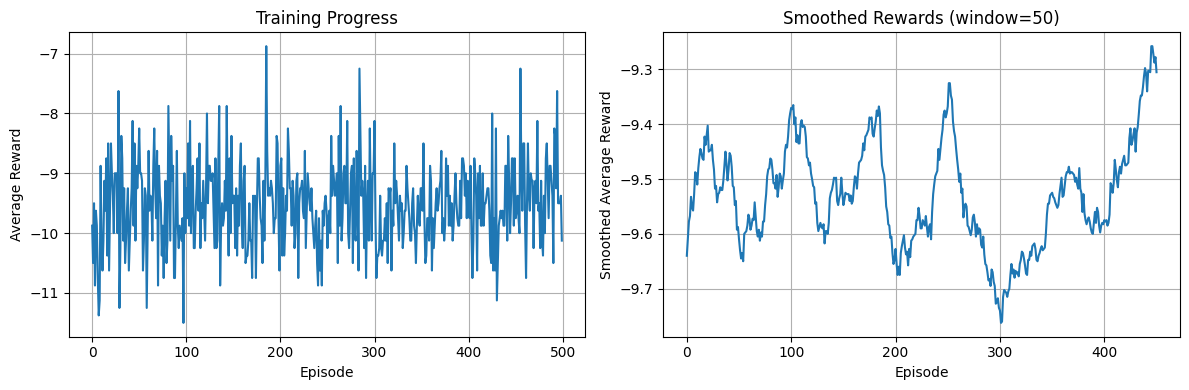

Training completed! Best performance: -6.88


In [12]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(mean_rewards)
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)

# Plot smoothed rewards
window = 50
if len(mean_rewards) >= window:
    smoothed = np.convolve(mean_rewards, np.ones(window)/window, mode='valid')
    plt.subplot(1, 2, 2)
    plt.plot(smoothed)
    plt.title(f'Smoothed Rewards (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Average Reward')
    plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Training completed! Best performance: {best_reward:.2f}")

# 3. AGENT TESTING

Load the best trained model and watch it play Pong!

In [20]:
# Load the best trained model
trained_policy = pong_utils.Policy().to(device)
trained_policy.load_state_dict(torch.load('best_pong_policy.pth', map_location=device))
trained_policy.eval()

print("✅ Best trained model loaded successfully!")
print("🎮 Ready to test the agent!")

✅ Best trained model loaded successfully!
🎮 Ready to test the agent!


In [21]:
# Test the trained agent (simplified - no animation)
print("🏓 Testing trained agent...")
print("Running a test game to evaluate performance...")

# Create a single test environment
test_env = gym.make(env_name, render_mode=None)

# Run a test game - need to collect two frames for the policy
obs, _ = test_env.reset()
total_reward = 0
steps = 0
done = False

# Initialize with first frame
frame1 = obs
step_result = test_env.step(1)  # Start game
frame2 = step_result[0]

while not done and steps < 1000:  # Limit steps to avoid infinite games
    # Use the two-frame input like in training
    frame_input = pong_utils.preprocess_batch([frame1, frame2])
    
    # Get action from policy
    with torch.no_grad():
        action_prob = trained_policy(frame_input)
        action = 4 if torch.rand(1) < action_prob else 5  # RIGHT=4, LEFT=5
    
    # Take action and get new frames
    step_result1 = test_env.step(action)
    frame1, reward, done = step_result1[:3]
    
    step_result2 = test_env.step(0)
    frame2, _, done = step_result2[:3]
    
    total_reward += reward
    steps += 1
    
    if done:
        break

test_env.close()
print(f"🎯 Test game completed!")
print(f"   Steps taken: {steps}")
print(f"   Total reward: {total_reward}")
print(f"   Performance: {'Good' if total_reward > -15 else 'Needs improvement'}")

# Run a few more test games for better evaluation
print("\n📊 Running 5 test games for better evaluation...")
test_rewards = []

for game in range(5):
    test_env = gym.make(env_name, render_mode=None)
    obs, _ = test_env.reset()
    total_reward = 0
    done = False
    
    # Initialize frames
    frame1 = obs
    step_result = test_env.step(1)
    frame2 = step_result[0]
    
    for step in range(1000):  # Max steps per game
        frame_input = pong_utils.preprocess_batch([frame1, frame2])
        
        with torch.no_grad():
            action_prob = trained_policy(frame_input)
            action = 4 if torch.rand(1) < action_prob else 5
        
        step_result1 = test_env.step(action)
        frame1, reward, done = step_result1[:3]
        
        step_result2 = test_env.step(0)
        frame2, _, done = step_result2[:3]
        
        total_reward += reward
        if done:
            break
    
    test_rewards.append(total_reward)
    test_env.close()
    print(f"   Game {game+1}: {total_reward}")

print(f"\n🏆 Average test performance: {np.mean(test_rewards):.2f}")
print(f"🎯 Best test game: {max(test_rewards)}")
print(f"📈 Training improved from random play (≈-21) to {np.mean(test_rewards):.2f}")

🏓 Testing trained agent...
Running a test game to evaluate performance...
🎯 Test game completed!
   Steps taken: 577
   Total reward: -9.0
   Performance: Good

📊 Running 5 test games for better evaluation...
🎯 Test game completed!
   Steps taken: 577
   Total reward: -9.0
   Performance: Good

📊 Running 5 test games for better evaluation...
   Game 1: -11.0
   Game 1: -11.0
   Game 2: -12.0
   Game 2: -12.0
   Game 3: -10.0
   Game 3: -10.0
   Game 4: -12.0
   Game 4: -12.0
   Game 5: -8.0

🏆 Average test performance: -10.60
🎯 Best test game: -8.0
📈 Training improved from random play (≈-21) to -10.60
   Game 5: -8.0

🏆 Average test performance: -10.60
🎯 Best test game: -8.0
📈 Training improved from random play (≈-21) to -10.60
